# Calculating RNBS
Lindsay Fitzpatrick
ljob@umich.edu
08/19/2024

This script uses the forecast data from CFS and runs it through the trained models to produce
an ensemble of RNBS forecasts for each of the Great Lakes. It saves the forecast values as a 
CSV and creates a timeseries plot that is saved as a PNG.

In [147]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import joblib
import calendar

User Input

In [184]:
# Directory to downloaded/processed CFS data
dir = f'C:/Users/fitzpatrick/Desktop/Data/'

# Read in the CSVs
pcp_data = pd.read_csv(dir+f'CFS/2018/CFS_APCP_Basin_Sums.csv',sep=',')
tmp_data = pd.read_csv(dir+f'CFS/2018/CFS_TMP_Basin_Avgs.csv',sep=',')
evap_data = pd.read_csv(dir+f'CFS/2018/CFS_EVAP_Basin_Sums.csv',sep=',')

# Open the trained model(s)
# For the MVP we are only going to use the GP model since it has the best performance
GP_model = joblib.load('GP_trained_model.joblib')

c:\Users\fitzpatrick\AppData\Local\miniconda3\envs\myenv\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator GaussianProcessRegressor from version 1.5.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Defined Functions

In [4]:
def seconds_in_month(year, month):
    # Number of days in the month
    num_days = calendar.monthrange(year, month)[1]
    # Convert days to seconds
    return num_days * 24 * 60 * 60

In [5]:
def convert_kg_to_cms(df):

    # Calculate the number of seconds for each month
    df['seconds'] = df.apply(lambda row: seconds_in_month(int(row['year']), int(row['month'])), axis=1)

    # Convert millimeters to meters
    df['WaterErie_m3'] = df['WaterErie'] / 1000
    df['WaterOntario_m3'] = df['WaterOntario'] / 1000
    df['WaterSuperior_m3'] = df['WaterSuperior'] / 1000
    df['WaterMichHuron_m3'] = (df['WaterMichigan'] + df['WaterHuron']) / 1000

    # Convert the data to cubic meters per second
    df['WaterErie_cms'] = df['WaterErie_m3'] / df['seconds']
    df['WaterOntario_cms'] = df['WaterOntario_m3'] / df['seconds']
    df['WaterSuperior_cms'] = df['WaterSuperior_m3'] / df['seconds']
    df['WaterMichHuron_cms'] = df['WaterMichHuron_m3'] / df['seconds']
    
    return df

In [6]:
def convert_cms_to_mm(df_cms):

    # Create a copy of the dataframe so we aren't altering the df_cms
    df_mm = df_cms.copy()

    sa_su = 82097*1000000
    sa_mh = (57753 + 5956)*1000000
    sa_er = 25655*1000000
    sa_on = 19009*1000000
    
    # Calculate the number of seconds for each month
    df_mm['seconds'] = df_mm.apply(lambda row: seconds_in_month(int(row['year']), int(row['month'])), axis=1)

    # value_cms / surface_area * seconds_in_a_month = m * 1000 = mm
    for column in df_mm.columns:
        if column.startswith("er"):
            df_mm[column] = df_mm[column] / sa_er * df_mm['seconds'] * 1000
        elif column.startswith("su"):
            df_mm[column] = df_mm[column] / sa_su * df_mm['seconds'] * 1000
        elif column.startswith("mih"):
            df_mm[column] = df_mm[column] / sa_mh * df_mm['seconds'] * 1000
        elif column.startswith("on"):
            df_mm[column] = df_mm[column] / sa_on * df_mm['seconds'] * 1000

    return df_mm

In [185]:
# Read in GLCC RNBS data
data_4 = pd.read_csv(dir + 'Input/rnbs_glcc.csv', sep=',')

# Ensure 'Date' column is treated as string and modified as necessary
date_strs = data_4['Date'].astype(str)

date_rnbs = []

for date_str in date_strs:
    # Insert leading zero before month (if necessary)
    if len(date_str) == 6:
        date_str = date_str[:4] + '0' + date_str[4:]

    # Insert leading zero before day (if necessary)
    if len(date_str) == 7:
        date_str = date_str[:6] + '0' + date_str[6:]

    # Convert to datetime object
    datetime_obj = datetime.strptime(date_str, '%Y%m%d')

    # Format the datetime object as a string in the desired format
    date_tmp = datetime_obj.strftime('%Y-%m-%d')

    # Append formatted date to list
    date_rnbs.append(date_tmp)

# Replace the original 'Date' column with formatted dates
data_4['Date'] = date_rnbs

# Convert 'Date' column to datetime format
data_4['Date'] = pd.to_datetime(data_4['Date'])

# Add a new column 'Month' extracting month from 'Date'
data_4['Month'] = data_4['Date'].dt.month

# Select only the data that matches with the CFSR dates
start_date = '2018-01-01'
end_date = '2018-12-01'
obs = data_4[(data_4['Date'] >= start_date) & (data_4['Date'] <= end_date)]

su_rnbs = obs['sup']
er_rnbs = obs['eri']
on_rnbs = obs['ont']
mh_rnbs = obs['mic_hur']

In [186]:
print(obs)

           Date         sup     mic_hur         eri         ont  Month
1416 2018-01-01  -16.346660   66.472910  110.703800  252.137400      1
1417 2018-02-01   18.898850  109.521300  293.305600  283.406100      2
1418 2018-03-01   -2.288532   47.906340  145.496500  207.313000      3
1419 2018-04-01   29.423990  185.222100  237.732600  425.651400      4
1420 2018-05-01  150.062300  216.839200  241.439800  221.320600      5
1421 2018-06-01  129.402300  123.333500   96.929620  124.713100      6
1422 2018-07-01  136.331100   30.256640    6.325933   47.625960      7
1423 2018-08-01   86.964220   74.953940  -15.814830   56.030540      8
1424 2018-09-01  120.543400   -1.774583  -62.239020   -9.489043      9
1425 2018-10-01  165.101300   83.664180 -109.649500   30.816800     10
1426 2018-11-01   28.474820   33.495250   78.564010  203.336600     11
1427 2018-12-01   -2.942399   69.911170   57.987720  275.950400     12


## Begin Script

Read in the precip, evap, and air temp forecasts from the CFS forecast. We add the totals for Mich and 
Huron together with the exception of air temp where we take the average of the two lakes. We put them all
into a new dataframe 'X' which will be our features to run through the models.

In [187]:
# Convert Total Precipitation to cms
pcp_data = convert_kg_to_cms(pcp_data)

# Convert Total Evaporation to cms
evap_data = convert_kg_to_cms(evap_data)

In [188]:
print(pcp_data)

           cfsrun  year  month     BasinErie     WaterErie      LandErie  \
0      2018010100  2018      1  7.292649e+12  1.247129e+12  6.777923e+12   
1      2018010100  2018      2  3.640429e+12  6.127626e+11  3.462988e+12   
2      2018010100  2018      3  6.929228e+12  1.113854e+12  6.830950e+12   
3      2018010100  2018      4  1.229824e+13  2.114171e+12  1.160793e+13   
4      2018010100  2018      5  1.051409e+13  1.569002e+12  1.072095e+13   
...           ...   ...    ...           ...           ...           ...   
13905  2018123100  2019      5  1.064493e+13  1.875161e+12  9.775497e+12   
13906  2018123100  2019      6  6.038744e+12  9.662792e+11  5.728047e+12   
13907  2018123100  2019      7  1.053738e+13  1.776340e+12  9.966349e+12   
13908  2018123100  2019      8  5.519257e+12  8.037327e+11  5.757188e+12   
13909  2018123100  2019      9  7.105253e+12  1.125599e+12  6.834530e+12   

       BasinOntario  WaterOntario   LandOntario    BasinHuron  ...  \
0      5.922652e+

In [189]:
# Features
X = pd.DataFrame({
    'su_pcp': pcp_data['WaterSuperior_cms'],
    'er_pcp': pcp_data['WaterErie_cms'],
    'on_pcp': pcp_data['WaterOntario_cms'],
    'mh_pcp': pcp_data['WaterMichHuron_cms'], #data_1['WaterMichigan']+data_1['WaterHuron'], # add the sums
    'su_evap': evap_data['WaterSuperior_cms'],
    'er_evap': evap_data['WaterErie_cms'],
    'on_evap': evap_data['WaterOntario_cms'],
    'mh_evap': evap_data['WaterMichHuron_cms'], #data_2['WaterMichigan']+data_2['WaterHuron'], # add the sums
    'su_tmp': tmp_data['WaterSuperior'],
    'er_tmp': tmp_data['WaterErie'],
    'on_tmp': tmp_data['WaterOntario'],
    'mh_tmp': (tmp_data['WaterMichigan']+tmp_data['WaterHuron'])/2 # take the average temp
})

### Predict Components using GP
Scale the data and run it through the trained GP model. Put the results into a new dataframe.

In [190]:
# Predict RNBS using GP

# Standardize the data
x_scaler = joblib.load('x_scaler.joblib')
y_scaler = joblib.load('y_scaler.joblib')
X_scaled = x_scaler.transform(X)

# Predict RNBS using GP
y_pred_scaled = GP_model.predict(X_scaled)

y_pred = y_scaler.inverse_transform(y_pred_scaled) # unscale the predictions
df_y_pred = pd.DataFrame(y_pred, columns=['sup', 'eri', 'ont', 'mih'])
print(df_y_pred)

c:\Users\fitzpatrick\AppData\Local\miniconda3\envs\myenv\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


               sup          eri          ont          mih
0       170.731657  1822.393208  1516.308382  3005.593863
1       808.100592   725.613374   996.060716  2925.584402
2       580.348463  1679.350415  1794.908959  4693.977709
3       707.701862  2818.870826  1444.428705  4979.252548
4      1089.058326   910.126983   345.813824  1599.241309
...            ...          ...          ...          ...
13905  1149.195003  1427.067524   987.262045  3434.119002
13906  1093.341648  -273.011017    55.250731  1320.081162
13907  3274.882242   431.576511   343.190532  2119.951861
13908  3684.031386  -489.119305   195.944279  1557.262972
13909  1940.471316   235.474713   392.975513  2793.450865

[13910 rows x 4 columns]


In [191]:
df = pd.DataFrame()
df['cfsrun'] = pcp_data['cfsrun']
df['month'] = pcp_data['month'].astype(int)
df['year'] = pcp_data['year'].astype(int)

In [192]:
df_y = pd.merge(df, df_y_pred, left_index=True, right_index=True, how='inner')

In [193]:
print(df_y)

           cfsrun  month  year          sup          eri          ont  \
0      2018010100      1  2018   170.731657  1822.393208  1516.308382   
1      2018010100      2  2018   808.100592   725.613374   996.060716   
2      2018010100      3  2018   580.348463  1679.350415  1794.908959   
3      2018010100      4  2018   707.701862  2818.870826  1444.428705   
4      2018010100      5  2018  1089.058326   910.126983   345.813824   
...           ...    ...   ...          ...          ...          ...   
13905  2018123100      5  2019  1149.195003  1427.067524   987.262045   
13906  2018123100      6  2019  1093.341648  -273.011017    55.250731   
13907  2018123100      7  2019  3274.882242   431.576511   343.190532   
13908  2018123100      8  2019  3684.031386  -489.119305   195.944279   
13909  2018123100      9  2019  1940.471316   235.474713   392.975513   

               mih  
0      3005.593863  
1      2925.584402  
2      4693.977709  
3      4979.252548  
4      1599.241309

Currently, we are only storing 1 set of model results

In [194]:
df_y.to_csv(dir+f'RNBS_forecasts_2018.csv',sep=',',index=False)

Convert component units from [cms] to [mm]

In [195]:
df_y_mm = convert_cms_to_mm(df_y)

In [196]:
def mean_min_max(df,lake):
    mean = df.groupby(['year', 'month'])[lake].median().reset_index()
    min = df.groupby(['year', 'month'])[lake].min().reset_index()
    max = df.groupby(['year', 'month'])[lake].max().reset_index()

    return mean, min, max

mean_su, min_su, max_su = mean_min_max(df_y_mm,'sup')
mean_er, min_er, max_er = mean_min_max(df_y_mm,'eri')
mean_on, min_on, max_on = mean_min_max(df_y_mm,'ont')
mean_mh, min_mh, max_mh = mean_min_max(df_y_mm,'mih')

In [197]:
df_y_mm_filtered = df_y_mm[(df_y_mm['year'] == 2018)]
print(df_y_mm_filtered)

           cfsrun  month  year         sup         eri         ont  \
0      2018010100      1  2018    5.570090  190.259130  213.650396   
1      2018010100      2  2018   23.812770   68.423460  126.764695   
2      2018010100      3  2018   18.933765  175.325362  252.905684   
3      2018010100      4  2018   22.343852  284.798799  196.957189   
4      2018010100      5  2018   35.530334   95.017896   48.725748   
...           ...    ...   ...         ...         ...         ...   
13635  2018122318     12  2018  130.105683   57.547687  234.982475   
13645  2018122400     12  2018  102.918653   91.900718  247.235142   
13655  2018122406     12  2018  112.630884   53.029402  239.463279   
13665  2018122412     12  2018  108.126063   58.961744  213.780779   
13675  2018122418     12  2018   80.165332   61.327046  236.555545   

              mih  seconds  
0      126.358640  2678400  
1      111.092213  2419200  
2      197.340249  2678400  
3      202.580838  2592000  
4       67.233

Begin plotting

[Text(0, 0, 'Jan'),
 Text(1, 0, 'Feb'),
 Text(2, 0, 'Mar'),
 Text(3, 0, 'Apr'),
 Text(4, 0, 'May'),
 Text(5, 0, 'Jun'),
 Text(6, 0, 'Jul'),
 Text(7, 0, 'Aug'),
 Text(8, 0, 'Sep'),
 Text(9, 0, 'Oct'),
 Text(10, 0, 'Nov'),
 Text(11, 0, 'Dec')]

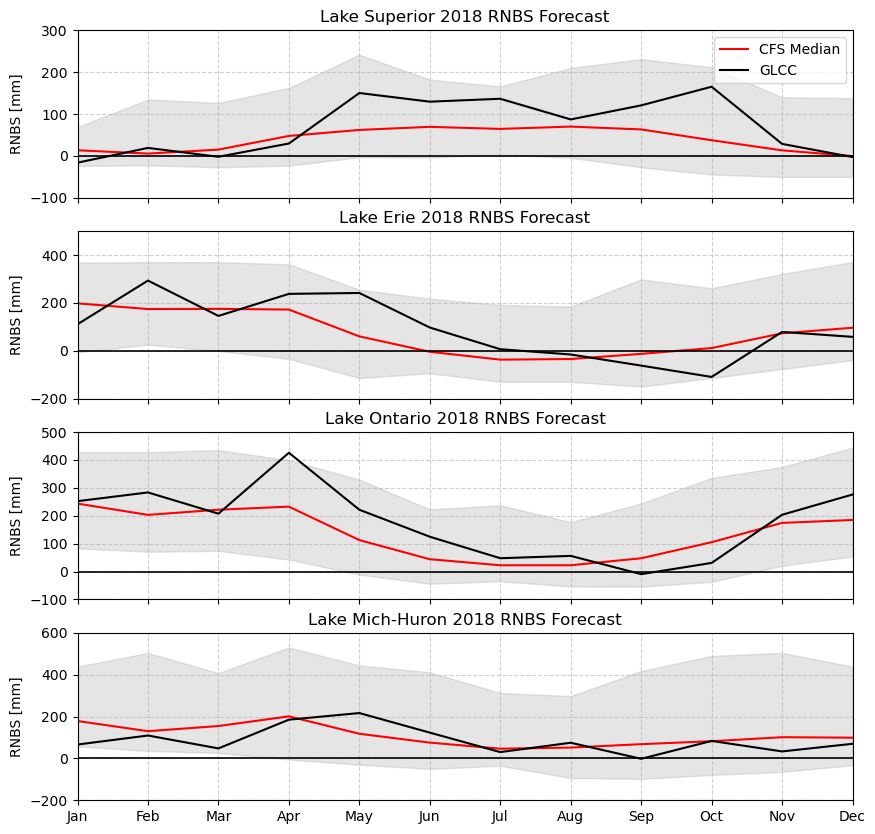

In [199]:
x_values = np.arange(0,12,1)  # x-axis values

# Creating a 4x1 grid of subplots
fig, axs = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

axs[0].plot(x_values, mean_su['sup'][0:12], color='red', linestyle='-', linewidth=1.5, label='CFS Median')
axs[0].plot(x_values, su_rnbs, color='black', linestyle='-', linewidth=1.5, label='GLCC')
axs[0].axhline(y=0, color='black', linestyle='-', linewidth=1.2)
axs[0].fill_between(x_values, min_su['sup'][0:12], max_su['sup'][0:12], color='gray', alpha=0.2)
axs[0].set_ylabel('RNBS [mm]')
axs[0].set_title('Lake Superior 2018 RNBS Forecast')
axs[0].set_ylim(-100, 300)
axs[0].set_xlim(0, 11)  # Setting x-axis limits from 1 to 12
axs[0].set_xticks(np.arange(0,12,1))
axs[0].legend(loc='upper right')
axs[0].grid(True, linestyle='--', alpha=0.6)

axs[1].plot(x_values, mean_er['eri'][0:12], color='red', linestyle='-', linewidth=1.5, label='Mean')
axs[1].plot(x_values, er_rnbs, color='black', linestyle='-', linewidth=1.5, label='Mean')
axs[1].axhline(y=0, color='black', linestyle='-', linewidth=1.2)
axs[1].fill_between(x_values, min_er['eri'][0:12], max_er['eri'][0:12], color='gray', alpha=0.2)
axs[1].set_ylabel('RNBS [mm]')
axs[1].set_title('Lake Erie 2018 RNBS Forecast')
axs[1].set_ylim(-200, 500)
axs[1].set_xlim(0, 11)  # Setting x-axis limits from 1 to 12
axs[1].set_xticks(np.arange(0,12,1))
axs[1].grid(True, linestyle='--', alpha=0.6)

axs[2].plot(x_values, mean_on['ont'][0:12], color='red', linestyle='-', linewidth=1.5, label='Mean')
axs[2].plot(x_values, on_rnbs, color='black', linestyle='-', linewidth=1.5, label='Mean')
axs[2].axhline(y=0, color='black', linestyle='-', linewidth=1.2)
axs[2].fill_between(x_values, min_on['ont'][0:12], max_on['ont'][0:12], color='gray', alpha=0.2)
axs[2].set_ylabel('RNBS [mm]')
axs[2].set_title('Lake Ontario 2018 RNBS Forecast')
axs[2].set_ylim(-100, 500)
axs[2].set_xlim(0, 11)  # Setting x-axis limits from 1 to 12
axs[2].set_xticks(np.arange(0,12,1))
axs[2].grid(True, linestyle='--', alpha=0.6)

axs[3].plot(x_values, mean_mh['mih'][0:12], color='red', linestyle='-', linewidth=1.5, label='Mean')
axs[3].plot(x_values, mh_rnbs, color='black', linestyle='-', linewidth=1.5, label='Mean')
axs[3].axhline(y=0, color='black', linestyle='-', linewidth=1.2)
axs[3].fill_between(x_values, min_mh['mih'][0:12], max_mh['mih'][0:12], color='gray', alpha=0.2)
axs[3].set_ylabel('RNBS [mm]')
axs[3].set_title('Lake Mich-Huron 2018 RNBS Forecast')
axs[3].set_ylim(-200, 600)
axs[3].set_xlim(0, 11)  # Setting x-axis limits from 1 to 12
axs[3].set_xticks(np.arange(0,12,1))
axs[3].grid(True, linestyle='--', alpha=0.6)
axs[3].set_xticklabels([calendar.month_abbr[mean_mh['month'][j]] for j in range(12)])

C:\Users\fitzpatrick\AppData\Local\Temp\1\ipykernel_3772\4234237901.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
C:\Users\fitzpatrick\AppData\Local\Temp\1\ipykernel_3772\4234237901.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])


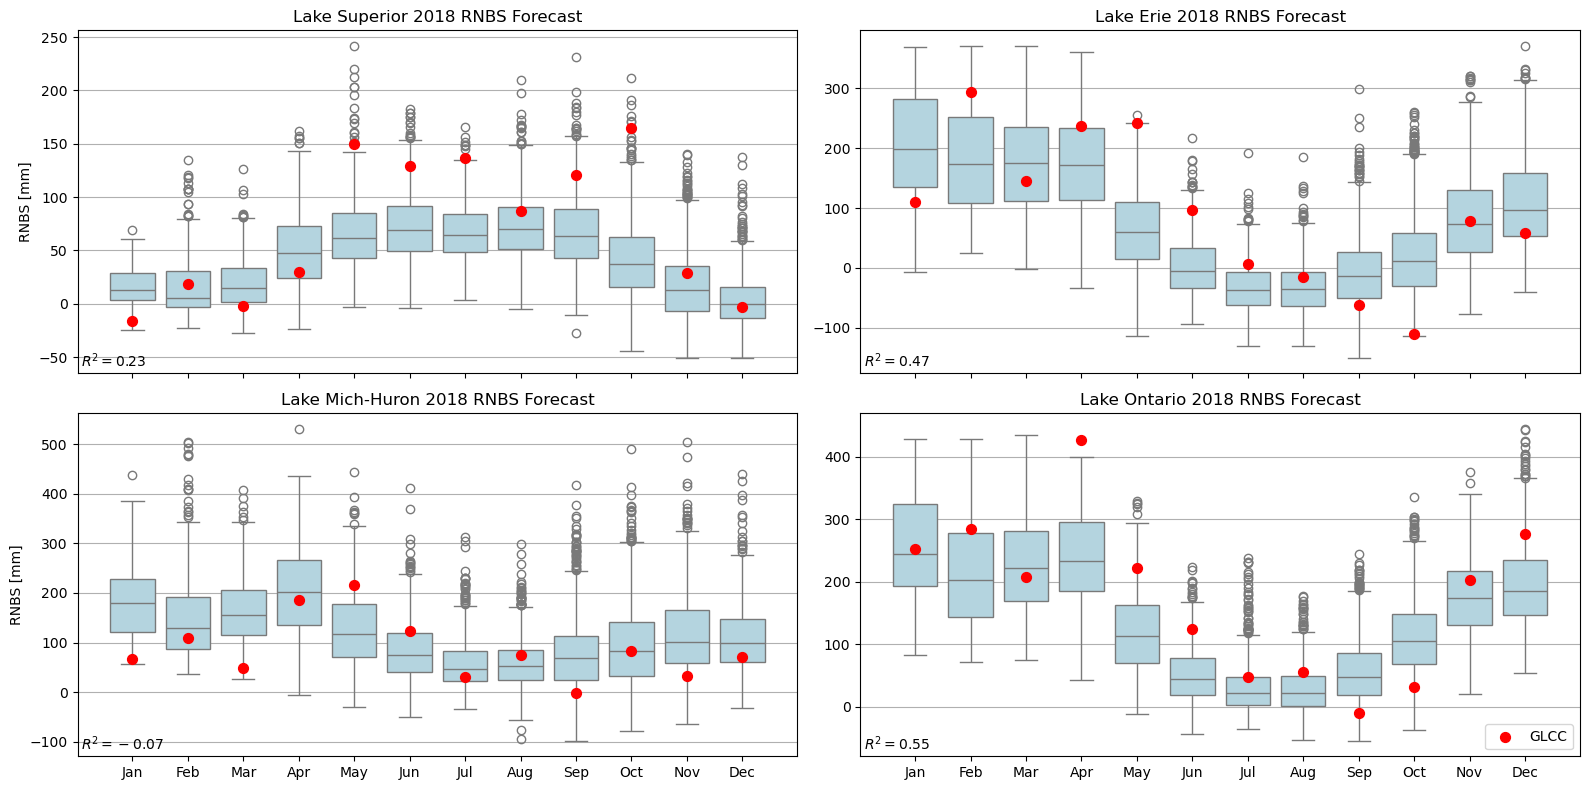

In [200]:
import seaborn as sns
from sklearn.metrics import r2_score

months = np.arange(0, 12)

# Create the 2x2 plot
fig, axes = plt.subplots(2, 2, figsize=(16, 8))

# First boxplot
sns.boxplot(x='month', y='sup', data=df_y_mm_filtered, color='lightblue', ax=axes[0, 0])
axes[0, 0].set_title('Lake Superior 2018 RNBS Forecast')
# Scatter plot for observations
axes[0, 0].scatter(obs['Month']-1, obs['sup'], color='red', label='GLCC', s=50, zorder=5)
axes[0, 0].set_ylabel('RNBS [mm]')
axes[0, 0].set_xlabel('')
axes[0, 0].set_xticklabels('')
axes[0, 0].grid(axis='y')

r2_1 = r2_score(obs['sup'],df_y_mm_filtered.groupby('month')['sup'].median())
axes[0, 0].text(0.005, 0.009, f'$R^2 = {r2_1:.2f}$', ha='left', va='bottom', transform=axes[0, 0].transAxes)

# Second boxplot
sns.boxplot(x='month', y='eri', data=df_y_mm_filtered, color='lightblue', ax=axes[0, 1])
axes[0, 1].set_title('Lake Erie 2018 RNBS Forecast')
# Scatter plot for observations
axes[0, 1].scatter(obs['Month']-1, obs['eri'], color='red', label='GLCC', s=50, zorder=5)
axes[0, 1].set_ylabel('')
axes[0, 1].set_xlabel('')
axes[0, 1].set_xticklabels('')
axes[0, 1].grid(axis='y')

r2_2 = r2_score(obs['eri'],df_y_mm_filtered.groupby('month')['eri'].median())
axes[0, 1].text(0.005, 0.009, f'$R^2 = {r2_2:.2f}$', ha='left', va='bottom', transform=axes[0, 1].transAxes)

# Third boxplot
sns.boxplot(x='month', y='mih', data=df_y_mm_filtered, color='lightblue', ax=axes[1, 0])
axes[1, 0].set_title('Lake Mich-Huron 2018 RNBS Forecast')
# Scatter plot for observations
axes[1, 0].scatter(obs['Month']-1, obs['mic_hur'], color='red', label='GLCC', s=50, zorder=5)
axes[1, 0].set_ylabel('RNBS [mm]')
axes[1, 0].set_xlabel('')
axes[1, 0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axes[1, 0].grid(axis='y')

r2_3 = r2_score(obs['mic_hur'],df_y_mm_filtered.groupby('month')['mih'].median())
axes[1, 0].text(0.005, 0.009, f'$R^2 = {r2_3:.2f}$', ha='left', va='bottom', transform=axes[1, 0].transAxes)

# Fourth boxplot
sns.boxplot(x='month', y='ont', data=df_y_mm_filtered, color='lightblue', ax=axes[1, 1])
axes[1, 1].set_title('Lake Ontario 2018 RNBS Forecast')
# Scatter plot for observations
axes[1, 1].scatter(obs['Month']-1, obs['ont'], color='red', label='GLCC', s=50, zorder=5)
axes[1, 1].set_ylabel('')
axes[1, 1].set_xlabel('')
axes[1, 1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axes[1, 1].grid(axis='y')
axes[1, 1].legend()

r2_4 = r2_score(obs['ont'],df_y_mm_filtered.groupby('month')['ont'].median())
axes[1, 1].text(0.005, 0.009, f'$R^2 = {r2_4:.2f}$', ha='left', va='bottom', transform=axes[1, 1].transAxes)

plt.tight_layout()
plt.show()

In [164]:
# Calculate important statistics
stats = df_y_mm_filtered.groupby('month')['mih'].describe()
print("Important values:\n", stats)

Important values:
         count        mean        std        min         25%         50%  \
month                                                                     
1        96.0  147.561776  65.129004  37.151777  105.544173  133.049028   
2       212.0  113.921754  53.589853  17.549025   75.995269  104.633857   
3       324.0  166.229172  91.657843  16.774826   89.683861  154.784663   
4       448.0  200.058484  98.638856   4.909243  125.499832  183.181960   
5       564.0  126.100136  80.623030 -48.755846   68.451523  112.291809   
6       672.0   89.702666  68.600178 -45.278379   43.306190   74.403928   
7       788.0   56.095150  52.125485 -69.819651   19.790410   50.185117   
8       912.0   57.301317  51.322189 -52.470353   21.981044   49.941617   
9      1036.0   74.422424  72.293883 -89.071502   25.081591   65.263563   
10     1156.0   90.218165  79.982790 -87.735831   34.248795   78.391561   
11     1156.0  109.171865  77.758431 -47.335164   53.952417   99.378338   
12    